上一章介绍了神经网络的学习，并通过数值微分计算了神经网络中损失函数关于权重参数的梯度。数值微分虽然简单，也容易实现，但缺点是计算上比较费时间。本章我们将学习一个能够高效计算权重参数的梯度的方法——误差反向传播法。

# 1. 链式法则

微积分中的链式法则用于计算复合函数的导数，反向传播是一种计算链式法则的运算，使用高效的特定运算顺序。

设 $x$ 是实数，$f$ 和 $g$ 是实数映射到实数的函数。假设 $y=g(x)$ 并且 $z = f(g(x))=f(y)$，那么链式法则为

$$ \frac{dz}{dx} = \frac{dz}{dy}\frac{dy}{dx} $$

我们可以将其从标量扩展到向量。假设 $X\in \mathbb{R}^m$，$Y\in \mathbb{R}^n$，$g$ 是从 $\mathbb{R}^m$ 到 $\mathbb{R}^n$ 的映射，$f$ 是从 $\mathbb{R}^n$ 到 $\mathbb{R}$ 的映射。如果$Y = g(X)$ 并且 $Z = f(Y)$，那么

$$ \frac{\partial Z}{\partial X_i} = \sum_j \frac{\partial Z}{\partial Y_j}\frac{\partial Y_j}{\partial X_i} $$

使用向量记法，可以等价地写成

$$ \nabla_X Z=(\frac{\partial Y}{\partial X})^\top \nabla_Y Z$$

其中，$\frac{\partial Y}{\partial X}$ 是 $g$ 的 $n\times m$ 的 Jacobian 矩阵。

## 前向传播

首先给出典型神经网络中的前向传播和**代价函数**的计算过程。代价函数等于损失函数加上正则项 $\Omega(\theta)$，其中 $\theta$ 包含所有参数（权重和偏置），损失函数 $L(y, t)$ 取决于神经网络输出 $ y$ 和目标 $t$。

$$ J = L(y, t) + \lambda \Omega(\theta) $$

Require: 网络深度 $l$

Require: $W^{(i)}, i\in {1,...,l}$，模型的权重矩阵

Require: $b^{(i)}, i\in {1,...,l}$，模型的偏置参数

Require: $x$，程序的输入

Require: $t$，目标输出

$z^{(0)} = x$

$ {\rm for \;} k=1,...,l {\rm \; do}$

$ \qquad a^{(k)} = W^{(k)}z^{(k-1)} + b^{(k)}$

$ \qquad z^{(k)} = f(a^{(k)})$

$ {\rm end \; for} $

$y = z^{(l)}$

$ J = L(y, t) + \lambda \Omega(\theta) $

## 反向传播

该计算对于每一层 $k$ 都产生了对激活 $a^{(k)} $ 的梯度，从输出层开始向后计算一直到第一个隐藏层。这些梯度可以看作对每层的输出应如何调整以减小误差的指导，根据这些梯度可以获得每层权重和偏置的梯度。

$ g \leftarrow \nabla_{y}J = \nabla_{y}L(y, t) $

$ {\rm for \;} k=l,l-1,...,1 {\rm \; do}$

     将关于层输出的梯度转换为非线性激活输入前的梯度：

$ \qquad g \leftarrow \nabla_{a^{(k)}}J = g f'(a^{(k)})$


     计算关于权重和偏置的梯度：
$ \qquad \nabla_{W^{(k)}} J = g z^{(k-1)\top} + \lambda \nabla_{W^{(k)}}\Omega(\theta)$

$ \qquad \nabla_{b^{(k)}} J = g + \lambda \nabla_{b^{(k)}}\Omega(\theta)$

     关于下一更低层的隐藏层传播梯度：
$ \qquad g \leftarrow \nabla_{z^{(k-1)}}J = W^{(k)\top}g$

$ {\rm end \; for} $

要正确理解和实现误差反向传播法，深度学习框架主要有两种方法：

- 基于数学式（Caffe）
- 基于计算图（Tensorflow，PyTorch）

# 2. 计算图(Computational Graph）
## 2.1 用计算图求解

**计算图** 是表达和评估数学表达式的一种方式，它被定义为有向图，其中节点对应于数学运算。

对于方程 $ p = x + y $ 的计算图如下：

![img](images/chapter11/computational_graph.png)

问题1： 在超市买了 2 个 100 元一个的苹果，额外的消费税是 10%，请计算支付金额。

![img](images/chapter11/apple_forward.png)

综上，用计算图解题的情况下，需要按如下流程进行。


1. 构建计算图。


2. 在计算图上，从左向右进行计算。

这里的第2 歩“从左向右进行计算”是正向传播（forward propagation）。正向传播是从计算图出发点到结束点的传播。而从右向左的传播被称为反向传播（backward propagation），它将在接下来的导数计算中发挥重要作用。

## 2.2 为何用计算图解题

- 无论全局是多么复杂的计算，都可以通过局部计算使各个节点致力于简单的计算，从而简化问题。


- 利用计算图可以将中间的计算结果全部保存起来。


- 可以通过反向传播高效计算导数。

这里，假设我们想知道苹果价格的上涨会在多大程度上影响最终的支付金额，即求“支付金额关于苹果的价格的导数”。设苹果的价格为 $x$，支付金额为 $L$，则相当于求 $\frac{\partial L}{\partial x}$。导数的数值可以通过计算图的反向传播求出来。


![img](images/chapter11/apple_backward.png)

从这个结果中可知，“支付金额关于苹果的价格的导数”的值是 2.2。这意味着，如果苹果的价格上涨 1 元，最终的支付金额会增加 2.2 元。

这里只求了关于苹果的价格的导数，不过“支付金额关于消费税的导数”、“支付金额关于苹果的个数的导数”等也都可以用同样的方式算出来。并且，计算中途求得的导数的结果（中间传递的导数）可以被共享，从而可以高效地计算多个导数。

综上，计算图的优点是，可以通过正向传播和反向传播高效地计算各个变量的导数值。

## 2.3. 计算图中的链式法则

复合函数是由多个函数构成的函数。例如，$z = (x + y)^2$ 可写为：

$$ z= t^2 $$
$$ t = x + y $$

复合函数的导数可以用构成复合函数的各个函数的导数的乘积表示。$z$ 关于 $x$ 的导数$ \frac{\partial z}{\partial x}$，可以用 $z$ 关于 $t$ 的导数 $\frac{\partial z}{\partial t}$ 和 $t$ 关于 $x$ 的导数 $\frac{\partial t}{\partial x}$ 的乘积表示。

$$ \frac{\partial z}{\partial x} = \frac{\partial z}{\partial t}\frac{\partial t}{\partial x} = 2t\cdot 1 = 2(x+y) $$

计算图的反向传播从右到左传播信号。反向传播的计算顺序是，先将节点的输入信号乘以节点的局部导数（偏导数），然后再传递给下一个节点。

![img](images/chapter11/chain1.png)

将求导结果带入上图中得到，
![img](images/chapter11/chain2.png)

# 3. 反向传播

## 3.1 加法层的反向传播

以 $z = x + y$ 为对象，观察它的反向传播。$z = x + y$ 的导数可解析性地计算出来。

$$ \frac{\partial z}{\partial x} = 1$$

$$ \frac{\partial z}{\partial y} = 1$$

反向传播将从上游传过来的导数（本例中是$ \frac{\partial L}{\partial z}$）乘以1，然后传向下游。也就是说，因为加法节点的反向传播只乘以1，所以输入的值会原封不动地流向下一个节点。

![img](images/chapter11/add_node.png)

接下来，我们实现加法节点的加法层，如下所示：

In [1]:
class AddLayer:
    def __init__(self):
        pass

    # 正向传播
    def forward(self, x, y):
        return x + y

    # 反向传播
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        # return dout, dout
        return dx, dy

加法层不需要特意进行初始化，所以 \_\_init\_\_() 中什么也不运行，只包含一行 pass 语句。加法层的 forward() 接收 x 和 y 两个参数，将它们相加后输出。backward() 将上游传来的导数（dout）原封不动地传递给下游。

## 3.2 乘法层的反向传播

这里我们考虑 $z = xy$。这个式的导数用下式表示：

$$ \frac{\partial z}{\partial x} = y$$

$$ \frac{\partial z}{\partial y} = x$$

乘法的反向传播会将上游的值乘以正向传播时的输入信号的“翻转值”后传递给下游。翻转值表示一种翻转关系，如下图所示，正向传播时信号是 x 的话，反向传播时则是 y；正向传播时信号是 y 的话，反向传播时则是 x。

![img](images/chapter11/multi_node.png)

In [2]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    # 正向传播
    def forward(self, x, y):
        self.x = x
        self.y = y
        return x * y

    # 反向传播
    def backward(self, dout):
        dx = dout * self.y # 翻转x和y
        dy = dout * self.x
        return dx, dy

\_\_init\_\_()中会初始化实例变量 x 和 y ，它们用于保存正向传播时的输入值。forward() 接收 x 和 y 两个参数，将它们相乘后输出。backward()将从上游传来的导数（dout）乘以正向传播的翻转值，然后传给下游。

现在我们使用 MulLayer 类实现前面的购买苹果的例子：

![img](images/chapter11/apple_backward_result.png)

In [3]:
apple = 100
apple_num = 2
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price) # 220

220.00000000000003


关于各个变量的导数可由 backward()求出。这里调用 backward()的顺序与调用 forward()的顺序相反。

In [4]:
# backward
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
print(dapple_price, dtax)

dapple, dapple_num = mul_apple_layer.backward(dapple_price)
print(dapple, dapple_num) # 2.2 110

1.1 200
2.2 110.00000000000001


## 3.3 激活函数层的反向传播

现在，我们将计算图的思路应用到神经网络中。这里，我们把构成神经网络的层实现为一个类。先来实现激活函数的 ReLU 层和 Sigmoid 层。

### 3.3.1 ReLU层

激活函数ReLU（Rectified Linear Unit）由下式表示，

$$ y = \begin{cases}
x&x > 0 \\
0&x <= 0
\end{cases} $$

可以求出 $y$ 关于 $x$ 的导数，

$$ \frac{\partial y}{\partial x} = \begin{cases}
1&x > 0 \\
0&x <= 0
\end{cases} $$

如果正向传播时的输入 $x$ 大于0，则反向传播会将上游的值原封不动地传给下游。反过来，如果正向传播时的 $x$ 小于等于0，则反向传播中传给下游的信号将停在此处。计算图如图所示，

![img](images/chapter11/relu.png)

现在我们来实现ReLU层。在神经网络的层的实现中，一般假定 forward() 和 backward() 的参数是NumPy数组。

In [5]:
class Relu:
    def __init__(self):
        self.mask = None
    
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        return dout

Relu 类有实例变量 mask，这个变量是由 True/False 构成的 NumPy 数组，它会把正向传播时的输入 $x$ 的元素中小于等于 0 的地方保存为 True，其它地方（大于 0 的元素）保存为 False。

In [6]:
import numpy as np
x = np.array( [[1.0, -0.5], [-2.0, 3.0]] )

Relu().forward(x)

array([[1., 0.],
       [0., 3.]])

### 3.3.2 Sigmoid层

sigmoid 函数公式为
$$ y = \frac{1}{1 + \exp (-x)} $$

用计算图表示的话如图所示，

![img](images/chapter11/sigmoid.png)

下面我们进行计算图的反向传播。

- 步骤1
      “/”节点表示 y = 1/t，其中t = 1 + exp(-x)，它的导数可以解析性地表示为下式。
$$\frac{\partial y}{\partial t} = - \frac{1}{t^2} = -y^2$$
- 步骤2
      “+”节点将上游的值原封不动地传给下游。
- 步骤3
      “exp”节点表示 y = exp(x)，它的导数为
$$ \frac{\partial y}{\partial x} = \exp(x) $$
- 步骤4
      “×”节点将正向传播时的值翻转后做乘法运算。因此，这里要乘以−1。

因此，Sigmoid层的反向传播计算图为：


![img](images/chapter11/sigmoid_result.png)

Sigmoid 层的反向传播输出为 $\frac{\partial L}{\partial y}y^2\exp(-x)$，可以进一步整理如下：

$$\frac{\partial L}{\partial y}y^2\exp(-x) = \frac{\partial L}{\partial y}y\frac{1}{1 + \exp (-x)}\exp(-x) = \frac{\partial L}{\partial y}y(1-y)$$

![img](images/chapter11/sigmoid_result_simple.png)

用 Python 代码实现sigmoid层：

In [7]:
class Sigmoid:
    def __init__(self):
        self.out = None    # 保存正向传播结果
        
    def forward(self, x):
        self.out = 1 / (1 + np.exp(-x))
        return self.out

    def backward(self, dout):
        return dout * self.out * (1.0 - self.out)

## 3.4 全连接层

考虑一个简单的神经网络全连接层计算：

In [8]:
X = np.random.rand(2) # 输入
W = np.random.rand(2,3) # 权重
B = np.random.rand(3) # 偏置

Y = np.dot(X, W) + B

这个计算过程可以用计算图表示出来。之前我们见到的计算图中各个节点间流动的是标量，而这个例子中各个节点间传播的是矩阵。

![img](images/chapter11/affine_forward.png)

以矩阵为对象的反向传播，按矩阵的各个元素进行计算时，步骤和以标量为对象的计算图相同。

$$ \frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y}\cdot W^T $$
$$ \frac{\partial L}{\partial W} = X^T\cdot \frac{\partial L}{\partial Y} $$

神经网络计算图的反向传播：

![img](images/chapter11/affine_backward.png)

现在我们考虑 N 个数据一起进行正向传播的情况，也就是批版本的全连接层。先给出批版本的全连接层的计算图，

![img](images/chapter11/affine_batch_backward.png)

与之前不同的是，现在输入 $X$ 的形状是 (N, 2)。

In [9]:
class FullyConnected:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
    
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx

## 3.5 Softmax-with-loss层

下面来实现 Softmax 层。考虑到这里也包含作为损失函数的交叉熵误差（cross entropy error），所以称为“Softmax-with-Loss 层”。Softmax-with-Loss 层（Softmax函数和交叉熵误差）的计算图如图所示。

![img](images/chapter11/softmax_with_loss.png)

Softmax 层将输入值归一化（将输出值的和调整为1）之后再输出。

### 3.5.1 正向传播

softmax 函数可由下式表示

$$ y_k = \frac{\exp (a_k)}{\sum_{i=1}^n \exp (a_i)} $$

在Softmax层的计算图中，指数的和记做 $S$，最终的输出记为 $(y_1,y_2,y_3)$

交叉熵误差(cross entropy error)可由下式表示，

$$ L = -\sum_k t_k \log y_k$$

交叉熵误差层的最终输出记为 $ -(t_1 \log y_1 + t_2 \log y_2 + t_3 \log y_3) $

### 3.5.2 反向传播

首先是 Cross Entropy Error 层的反向传播，
![img](images/chapter11/cross_entropy_backward.png)

其中注意“ log”节点的反向传播遵从：
$$ y= log(x)$$
$$ \frac{\partial y}{\partial x} = \frac{1}{x} $$

下面是Softmax 层的反向传播的步骤，稍有些复杂。我们将它分为两部分来讨论，

![img](images/chapter11/softmax_backward1.png)

1. “×”节点将正向传播的值翻转后相乘。

$$ -\frac{t_1}{y_1}\exp(a_1) = -t_1\frac{S}{\exp (a_1)}\exp(a_1)=-t_1 S $$

2. 正向传播时若有分支流出，则反向传播时它们的反向传播的值会相加。

$$ (-t_1S - t_2S - t_3S)\cdot -(\frac{1}{S})^2 = \frac{1}{S}(t_1+t_2+t_3) = \frac{1}{S} $$

这里，$(t_1, t_2, t_3)$ 是 one-hot 向量，意味着 $(t_1, t_2, t_3)$ 中只有一个元素是1，其余都是0。因此，$t_1+t_2+t_3 = 1$

3. “+”节点原封不动地传递上游的值。

![img](images/chapter11/softmax_backward2.png)

1. “×”节点将值翻转后相乘。

$$ -\frac{t_1}{y_1} \frac{1}{S} = -\frac{t_1}{\exp (a_1)} $$

2. 根据“exp”节点的关系式 $ \frac{\partial y}{\partial x} = \exp(x) $，向两个分支输入的和乘以 $\exp(a_1)$ 后的值就是我们要求的反向传播。

$$ (\frac{1}{S} - \frac{t_1}{\exp(a_1)}) \exp(a_1) = \frac{\exp(a_1)}{S} - t_1 = y_1 - t_1 $$

3. 剩下的 $a_2$、$a_3$ 也可以按照相同的步骤求出。

Softmax 层的反向传播得到了 $(y_1 − t_1, y_2 − t_2, y_3 − t_3)$ 这样“漂亮”的结果。由于 $(y_1, y_2, y_3)$ 是 Softmax 层的输出，$(t_1, t_2, t_3)$ 是标签数据，所以 $(y_1 − t_1, y_2 − t_2, y_3 − t_3)$ 是 Softmax 层的输出和标签的差分。

例如，Softmax 层的输出是 $y=(0.3, 0.2, 0.5)$ ，标签数据是 $t =(0, 1, 0)$。因为正确解标签处的概率是 0.2（20%），这时的神经网络未能进行正确的识别。此时，Softmax 层的反向传播传递的是 (0.3, −0.8, 0.5) 这样一个大的误差。

现在来进行Softmax-with-Loss 层的实现，实现代码如下所示

In [10]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 损失
        self.y = None # softmax的输出
        self.t = None # 标签数据（one-hot vector）
    
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

注意反向传播时，将要传播的值除以批的大小（batch_size）后，将单个数据的误差传递给前面的层。

# 4. 误差反向传播的实现

回顾神经网络学习的步骤如下：
- 前提
      神经网络中有合适的权重和偏置，调整权重和偏置以便拟合训练数据的过程称为学习。神经网络的学习分为下面 4 个步骤。
      
- 步骤1（mini-batch）
      从训练数据中随机选择一部分数据。

- 步骤2（计算梯度）
      计算损失函数关于各个权重参数的梯度。

- 步骤3（更新参数）
      将权重参数沿梯度方向进行微小的更新。

- 步骤4（重复）
      重复步骤1、步骤2、步骤3。

上一章中，我们利用数值微分求得了权重参数的梯度。数值微分虽然实现简单，但是计算要耗费较多的时间。和需要花费较多时间的数值微分不同，误差反向传播法可以快速高效地计算梯度。

## 4.1 神经网络的实现

通过像组装乐高积木一样组装上一节中实现的层，可以构建神经网络。本节我们将通过组装已经实现的层来构建神经网络，这里我们将 2 层神经网络实现为TwoLayerNet 类。

TwoLayerNet类的方法：

|方法|说明|
|:---|:---|
|__init__(self, input_size, hidden_size, output_size)|进行初始化。参数从头开始依次表示输入层的神经元数、隐藏层的神经元数、输出层的神经元数|
|predict(self, x)|进行识别（推理）。参数 x 是图像数据|
|loss(self, x, t)|计算损失函数的值。参数 x 是图像数据，t 是正确解标签|
|accuracy(self, x, t) |计算识别精度|
|gradient(self, x, t) | 通过误差反向传播法计算关于权重参数的梯度|

In [11]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # 生成层
        self.layers = OrderedDict()   # 有序字典
        self.layers['FC1'] = FullyConnected(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['FC2'] = FullyConnected(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    # x:输入数据, t:监督数据
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 :
            t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x:输入数据, t:标签数据
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 设定
        grads = {}
        grads['W1'] = self.layers['FC1'].dW
        grads['b1'] = self.layers['FC1'].db
        grads['W2'] = self.layers['FC2'].dW
        grads['b2'] = self.layers['FC2'].db
        return grads

In [12]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 溢出对策
    return np.exp(x) / np.sum(np.exp(x))

OrderedDict 是有序字典，“有序”是指它可以记住向字典里添加元素的顺序。因此，神经网络的正向传播只需按照添加元素的顺序调用各层的 forward() 方法就可以完成处理，而反向传播只需要按照相反的顺序调用各层即可。

所以这里要做的事情仅仅是以正确的顺序连接各层，再按顺序（或者逆序）调用各层。

像这样通过将神经网络的组成元素以层的方式实现，可以轻松地构建神经网络。这个用层进行模块化的实现具有很大优点。因为想另外构建一个神经网络（例如 10 层、20 层，甚至更深的神经网络）时，只需像组装乐高积木那样添加必要的层就可以了。之后，通过各个层内部实现的正向传播和反向传播，就可以正确计算进行识别处理或学习所需的梯度。

## 4.2 使用误差反向传播法的学习

到目前为止，我们介绍了两种求梯度的方法。一种是基于数值微分的方法，计算很耗费时间；另一种是解析性地求解数学式的方法，它通过使用误差反向传播法，即使存在大量的参数，也可以高效地计算梯度。因此，后文将不再使用耗费时间的数值微分，而是使用误差反向传播法求梯度。

为了计算方便，使用 change_one_hot_label() 函数将 MNIST 的标签数据改为 one-hot 类型。同时，SoftmaxWithLoss 类中的 backward() 方法也需要进行相应更改。

In [13]:
def change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T

In [14]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 监督数据是one-hot-vector的情况下，转换为正确解标签的索引
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [15]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 损失
        self.y = None # softmax的输出
        self.t = None # 标签数据（one-hot vector）

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 监督数据是one-hot-vector的情况
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

我们来看一下基于 MNIST 数据库，使用了误差反向传播法的神经网络的学习的实现。和之前的实现相比，不同之处仅在于通过误差反向传播法求梯度这一点。

In [16]:
from demo_code.download import load_mnist
from collections import OrderedDict

(x_train, t_train), (x_test, t_test) = load_mnist()
x_train = x_train.reshape(x_train.shape[0], -1)
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1)
x_test = x_test.astype(np.float32) / 255.0

t_train = change_one_hot_label(t_train)
t_test = change_one_hot_label(t_test)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 6000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 通过误差反向传播法求梯度
    grad = network.gradient(x_batch, t_batch)
    
    # 更新参数
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print('train acc, test acc | {0:.4f}, {1:.4f}'.format(train_acc, test_acc))

Dataset loading completed
train acc, test acc | 0.1211, 0.1213
train acc, test acc | 0.9036, 0.9054
train acc, test acc | 0.9239, 0.9245
train acc, test acc | 0.9362, 0.9348
train acc, test acc | 0.9456, 0.9434
train acc, test acc | 0.9516, 0.9489
train acc, test acc | 0.9566, 0.9543
train acc, test acc | 0.9607, 0.9565
train acc, test acc | 0.9630, 0.9594
train acc, test acc | 0.9676, 0.9609


最后可以用 Matplotlib 将训练过程中的训练集和测试集精度绘制出来。

In [17]:
import matplotlib.pyplot as plt

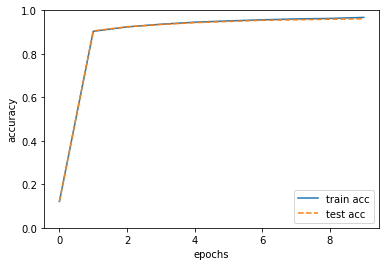

In [18]:
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()